In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import linear_model, preprocessing
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
df = pd.read_excel('https://archive.ics.uci.edu/ml/machine-learning-databases/00342/Data_Cortex_Nuclear.xls',index_col='MouseID')
df.head()

,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N,NR2A_N,pAKT_N,pBRAF_N,pCAMKII_N,pCREB_N,pELK_N,...,pCFOS_N,SYP_N,H3AcK18_N,EGR1_N,H3MeK4_N,CaNA_N,Genotype,Treatment,Behavior,class
MouseID,,,,,,,,,,,,,,,,,,,,,
309_1,0.503644,0.747193,0.430175,2.816329,5.990152,0.218830,0.177565,2.373744,0.232224,1.750936,...,0.108336,0.427099,0.114783,0.131790,0.128186,1.675652,Control,Memantine,C/S,c-CS-m
309_2,0.514617,0.689064,0.411770,2.789514,5.685038,0.211636,0.172817,2.292150,0.226972,1.596377,...,0.104315,0.441581,0.111974,0.135103,0.131119,1.743610,Control,Memantine,C/S,c-CS-m
309_3,0.509183,0.730247,0.418309,2.687201,5.622059,0.209011,0.175722,2.283337,0.230247,1.561316,...,0.106219,0.435777,0.111883,0.133362,0.127431,1.926427,Control,Memantine,C/S,c-CS-m
309_4,0.442107,0.617076,0.358626,2.466947,4.979503,0.222886,0.176463,2.152301,0.207004,1.595086,...,0.111262,0.391691,0.130405,0.147444,0.146901,1.700563,Control,Memantine,C/S,c-CS-m
309_5,0.434940,0.617430,0.358802,2.365785,4.718679,0.213106,0.173627,2.134014,0.192158,1.504230,...,0.110694,0.434154,0.118481,0.140314,0.148380,1.839730,Control,Memantine,C/S,c-CS-m


To deal with missing values we create a new data frame df1 where the missing values in each column are filled with the mean values from the non-missing values.


In [3]:
df1=df.fillna(df.mean())
df1.shape

(1080, 81)

We will first predict the binary class label in df1['Genotype'] which indicates if the mouse has Down's syndrome or not. String values in df1['Genotype'].values are converted to a numeric vector y with 0 or 1

In [4]:
temp=df1['Genotype'].values
y=np.unique(temp,return_inverse=True)[1]
print(y)

[0 0 0 ... 1 1 1]


Predictions are done using the Standardized expression level of 77 genes

In [19]:
temp1=df1.values
Xs=temp1[:,:77]
scaler = StandardScaler()
Xs = scaler.fit_transform(Xs)
print(Xs)

[[ 0.31271112  0.5179336   2.2536689  ... -1.41662394 -1.60789061
   1.06590091]
 [ 0.35679793  0.28650133  1.8802795  ... -1.32521803 -1.54684392
   1.28029118]
 [ 0.33496588  0.45046461  2.01292763 ... -1.37325709 -1.62359464
   1.85703831]
 ...
 [-0.79192771 -0.88354273 -1.72382963 ...  1.27078193  3.11724261
   0.29352469]
 [-0.82188815 -0.8130138  -1.52387571 ...  1.88117889  3.32828966
   0.2089962 ]
 [-0.49491588 -0.62125474 -1.26845332 ...  1.92748438  3.32672533
   0.10478825]]


In [20]:
scaler = StandardScaler()
Xs = scaler.fit_transform(Xs)

In [21]:
logreg = linear_model.LogisticRegression(C=1e5, max_iter=1000)
logreg.fit(Xs, y)

LogisticRegression(C=100000.0, max_iter=1000)

In [22]:
yhat = logreg.predict(Xs)
acc = np.mean(yhat == y)
print("Accuracy on training data = %f" % acc)


Accuracy on training data = 1.000000


indices of the maximum coefficeint vector= 43.81479134312627,108.03864277845705


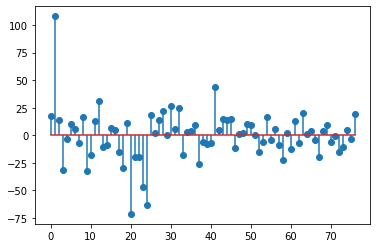

In [26]:
coef=logreg.coef_
#print(coef)
plt.stem(coef[0,:],use_line_collection='True')
coef1=np.reshape(coef.T,(77,))
coef1=np.sort(coef1)
i=coef1[75:][0]
j=coef1[75:][1]
print('indices of the maximum coefficeint vector= {},{}'.format(i,j))

These are the genes that are
likely to be most involved in Down's Syndrome

The above meaured the accuracy on the training data. It is more accurate to measure the accuracy
on the test data. Perform 10-fold cross validation and measure the average precision, recall and
f1-score, as well as the AUC

In [28]:
from sklearn.model_selection import KFold
from sklearn.metrics import precision_recall_fscore_support
nfold = 10
kf = KFold(n_splits=nfold,shuffle=True)
prec = []
rec = []
f1 = []
acc = []
for train, test in kf.split(Xs):
 # Get training and test data
    Xtr = Xs[train,:]
    ytr = y[train]
    Xts = Xs[test,:]
    yts = y[test]

 # Fit a model
    logreg.fit(Xtr, ytr)
    yhat = logreg.predict(Xts)

 # Measure performance
    preci,reci,f1i,_= precision_recall_fscore_support(yts,yhat,average='binary')
    prec.append(preci)
    rec.append(reci)
    f1.append(f1i)
    acci = np.mean(yhat == yts)
    acc.append(acci)
# Take average values of the metrics
precm = np.mean(prec)
recm = np.mean(rec)
f1m = np.mean(f1)
accm= np.mean(acc)
# Compute the standard errors
prec_se = np.std(prec)/np.sqrt(nfold-1)
rec_se = np.std(rec)/np.sqrt(nfold-1)
f1_se = np.std(f1)/np.sqrt(nfold-1)
acc_se = np.std(acc)/np.sqrt(nfold-1)
print('Precision = {0:.4f}, SE={1:.4f}'.format(precm,prec_se))
print('Recall = {0:.4f}, SE={1:.4f}'.format(recm, rec_se))
print('f1 = {0:.4f}, SE={1:.4f}'.format(f1m, f1_se))
print('Accuracy = {0:.4f}, SE={1:.4f}'.format(accm, acc_se))

<generator object _BaseKFold.split at 0x000002302766B6C8>
Precision = 0.9378, SE=0.0133
Recall = 0.9572, SE=0.0070
f1 = 0.9467, SE=0.0066
Accuracy = 0.9500, SE=0.0056


Multi-Class Classification:
Demonstration of multi-class calssification on df['class'].
This has 8 possible classes.

In [31]:
temp=df1['class'].values
y=np.unique(temp,return_inverse=True)[1]
print(y)


[0 0 0 ... 7 7 7]


In [32]:
logreg = linear_model.LogisticRegression(C=1,multi_class='ovr')
logreg.fit(Xs, y)

LogisticRegression(C=1, multi_class='ovr')

In [33]:
yhat = logreg.predict(Xs)
acc = np.mean(yhat == y)
print("Accuracy on training data = %f" % acc)

Accuracy on training data = 0.999074


In [38]:
nfold = 10
kf = KFold(n_splits=nfold,shuffle=True)
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
for train, test in kf.split(Xs):
    prec = []
    rec = []
    f1 = []
    acc = []
 # Get training and test data
    Xtr = Xs[train,:]
    ytr = y[train]
    Xts = Xs[test,:]
    yts = y[test]
    
 # Fit a model
    logreg.fit(Xtr, ytr)
    yhat = logreg.predict(Xts)
    
    c1=confusion_matrix(yts, yhat, labels=None, sample_weight=None)
    c=preprocessing.normalize(c1)
    print(np.array_str(c, precision=4, suppress_small=True)) 
    preci,reci,f1i,_= precision_recall_fscore_support(yts,yhat)
    prec.append(preci)
    rec.append(reci)
    f1.append(f1i)
    acci = np.mean(yhat == yts)
    acc.append(acci)
precm = np.mean(prec)
recm = np.mean(rec)
f1m = np.mean(f1)
accm= np.mean(acc)
# Compute the standard errors
prec_se = np.std(prec)/np.sqrt(nfold-1)
rec_se = np.std(rec)/np.sqrt(nfold-1)
f1_se = np.std(f1)/np.sqrt(nfold-1)
acc_se = np.std(acc)/np.sqrt(nfold-1)
print('Precision = {0:.4f}, SE={1:.4f}'.format(precm,prec_se))
print('Recall = {0:.4f}, SE={1:.4f}'.format(recm, rec_se))
print('f1 = {0:.4f}, SE={1:.4f}'.format(f1m, f1_se))
print('Accuracy = {0:.4f}, SE={1:.4f}'.format(accm, acc_se))

[[1.     0.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.9978 0.     0.     0.     0.0665 0.     0.    ]
 [0.     0.     1.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.     1.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     1.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     1.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.     1.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.     1.    ]]
[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]
[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]
[[0.9975 0.     0.     0.     0.0712 0.     0.     0.    ]
 [0.     1.     0.     0.     0.  

C:\Users\Blackfish96\miniconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:4: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  after removing the cwd from sys.path.


<StemContainer object of 3 artists>

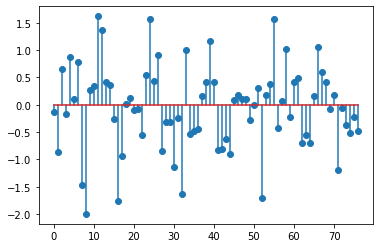

In [39]:
ytr = logreg.predict(Xtr)
coef=logreg.coef_
coef.shape
plt.stem(coef[0,:])

Line plot of coefficients